=== LOADED ===
Shape: (96672, 2)
Time range: 2015-01-01 00:00:00 to 2026-01-10 23:00:00
Columns: ['load_MW', 'load_with_pumping_MW']



,load_MW,load_with_pumping_MW
timestamp,,
2015-01-01 00:00:00,6815.350,6815.350
2015-01-01 01:00:00,6721.000,6721.000
2015-01-01 02:00:00,6601.800,6606.917
2015-01-01 03:00:00,6506.400,6634.833
2015-01-01 04:00:00,6441.067,6957.633


,load_MW,load_with_pumping_MW
timestamp,,
2026-01-10 19:00:00,9820.134,9820.134
2026-01-10 20:00:00,9679.233,9679.233
2026-01-10 21:00:00,9258.650,9258.650
2026-01-10 22:00:00,8981.000,8981.000
2026-01-10 23:00:00,8638.750,8638.750


=== DTYPES ===
0
load_MW                 float64
load_with_pumping_MW    float64
dtype: object

=== DUPLICATE TIMESTAMPS ===
Duplicate timestamp count: 11
Index unique now?: True



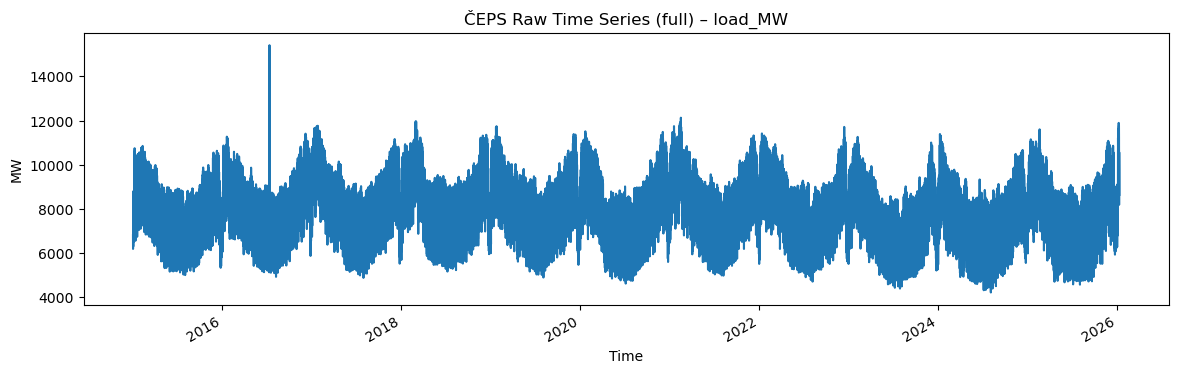

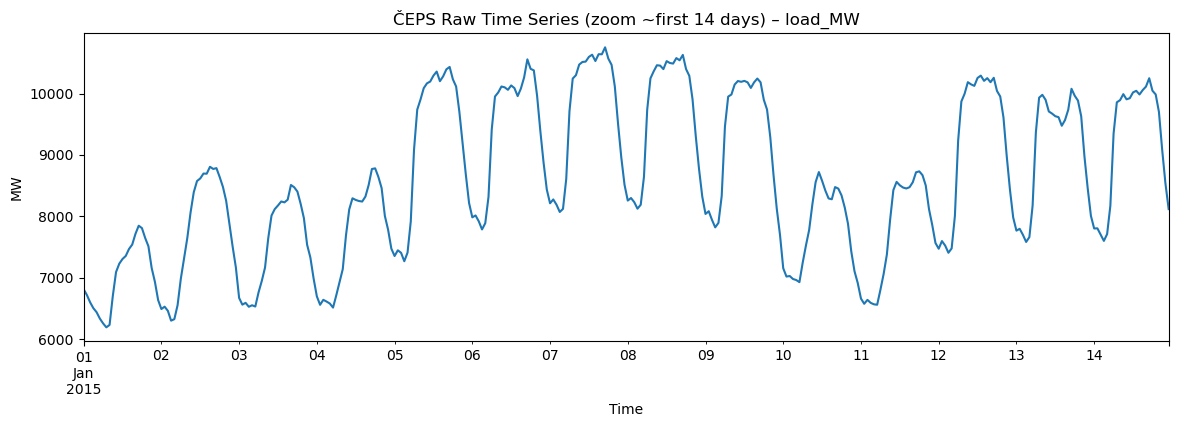

=== MISSING VALUES (COUNT) ===
0
load_MW                 0
load_with_pumping_MW    0
dtype: int64

=== MISSING VALUES (%) ===
0
load_MW                 0.0
load_with_pumping_MW    0.0
dtype: float64

=== MISSING GAP LENGTHS (in timesteps) ===
No missing gaps detected in target.

=== FREQUENCY CHECK ===
Inferred frequency: None

Most common time deltas:
timestamp
0 days 01:00:00    96649
0 days 02:00:00       11
Name: count, dtype: int64

If reindexed to 'h', missing target values would be: 0.0114%

=== FEATURE SUMMARY ===
Number of rows: 96661
Number of columns: 2
Numeric columns: ['load_MW', 'load_with_pumping_MW']



,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
load_MW,96661.0,7988.170989,1403.586604,4224.167,6922.017,7970.90,8931.917,15412.6
load_with_pumping_MW,96661.0,8153.807181,1354.685052,4224.167,7183.133,8169.05,9069.500,15412.6



DATASET SUITABILITY VERDICT
Verdict: SUITABLE

Why:
1) Long history available (~11.0 years), good for seasonality and forecasting.
2) Sampling is (mostly) hourly, suitable for standard forecasting pipelines.
3) Low missingness in target (0.000%), excellent.
4) Duplicate timestamps were found (11) and aggregated by mean to ensure a unique hourly index.


In [1]:
# ============================================================
# CEPS Dataset Assessment Notebook (Full, Robust Pipeline)
# Works with CEPS semicolon CSV exports that include metadata rows.
#
# Outputs:
# 1) Load + clean data
# 2) Plot raw time series (full + zoom)
# 3) Missing values (count, %, gap lengths)
# 4) Frequency checks (infer + delta distribution)
# 5) Duplicate timestamp handling
# 6) Feature description (dtypes + stats)
# 7) Final conclusion: Suitable / Not suitable + why
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# SETTINGS (EDIT THESE)
# -----------------------------
FILE_NAME = "data (1).csv"      # <-- your downloaded file
EXPECTED_FREQ = "h"             # hourly. (use 'h' not 'H')
TARGET_COL = "load_MW"          # our main forecasting target
# -----------------------------


# ============================================================
# 1) LOAD + CLEAN
# ============================================================

# CEPS exports: semicolon separated; often first row is metadata
raw = pd.read_csv(FILE_NAME, sep=";", skiprows=1)

# Promote first row to header; drop it from data
raw.columns = raw.iloc[0]
raw = raw.drop(index=0).reset_index(drop=True)

# Drop columns whose names are NaN (trailing separators create these)
raw = raw.loc[:, raw.columns.notna()]

# Rename Czech -> English (if present)
rename_map = {
    "Datum": "timestamp",
    "Zatížení [MW]": "load_MW",
    "Zatížení s čerpáním [MW]": "load_with_pumping_MW",
}
raw = raw.rename(columns=rename_map)

# Keep only relevant columns if available
keep_cols = [c for c in ["timestamp", "load_MW", "load_with_pumping_MW"] if c in raw.columns]
df = raw[keep_cols].copy()

# Convert numeric columns robustly
for col in ["load_MW", "load_with_pumping_MW"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)  # EU decimal comma to dot
            .replace("nan", np.nan)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Parse timestamp (CEPS format: dd.mm.yyyy HH:MM)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d.%m.%Y %H:%M", errors="coerce")

# Drop rows with invalid timestamps
df = df.dropna(subset=["timestamp"])

# Sort and set index
df = df.sort_values("timestamp").set_index("timestamp")

print("=== LOADED ===")
print("Shape:", df.shape)
print("Time range:", df.index.min(), "to", df.index.max())
print("Columns:", list(df.columns))
print()


# ============================================================
# 2) QUICK INSPECTION
# ============================================================
display(df.head())
display(df.tail())

print("=== DTYPES ===")
print(df.dtypes)
print()


# ============================================================
# 3) HANDLE DUPLICATE TIMESTAMPS (IMPORTANT)
# ============================================================
df = df.sort_index()
dup_count = df.index.duplicated().sum()
print("=== DUPLICATE TIMESTAMPS ===")
print("Duplicate timestamp count:", dup_count)

# If duplicates exist, aggregate to unique timestamps (mean for load)
if dup_count > 0:
    df = df.groupby(df.index).mean(numeric_only=True)

print("Index unique now?:", df.index.is_unique)
print()


# ============================================================
# 4) PLOT RAW TIME SERIES
# ============================================================
# Determine target column
if TARGET_COL not in df.columns:
    # fallback to first numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found to use as a target.")
    TARGET_COL = numeric_cols[0]
    print(f"TARGET_COL not found, using fallback target: {TARGET_COL}")

# Full plot
plt.figure(figsize=(14,4))
df[TARGET_COL].plot()
plt.title(f"ČEPS Raw Time Series (full) – {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

# Zoom plot (first 14 days assuming hourly)
plt.figure(figsize=(14,4))
df[TARGET_COL].iloc[:24*14].plot()
plt.title(f"ČEPS Raw Time Series (zoom ~first 14 days) – {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()


# ============================================================
# 5) MISSING VALUES CHECK
# ============================================================
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

print("=== MISSING VALUES (COUNT) ===")
print(missing_counts)
print()

print("=== MISSING VALUES (%) ===")
print(missing_pct.round(4))
print()

# Missing gap length distribution for the target
is_missing = df[TARGET_COL].isna()
runs = (is_missing != is_missing.shift()).cumsum()
gap_lengths = is_missing.groupby(runs).sum()
gap_lengths = gap_lengths[gap_lengths > 0]

print("=== MISSING GAP LENGTHS (in timesteps) ===")
if len(gap_lengths) == 0:
    print("No missing gaps detected in target.")
else:
    print(gap_lengths.describe())
print()


# ============================================================
# 6) FREQUENCY / REGULARITY CHECKS
# ============================================================
freq_inferred = pd.infer_freq(df.index)
print("=== FREQUENCY CHECK ===")
print("Inferred frequency:", freq_inferred)

delta_counts = df.index.to_series().diff().value_counts().head(10)
print("\nMost common time deltas:")
print(delta_counts)
print()

# Reindex to hourly grid to quantify missing timestamps/values
full_index = pd.date_range(df.index.min(), df.index.max(), freq=EXPECTED_FREQ)
df_regular = df.reindex(full_index)

introduced_missing_pct = df_regular[TARGET_COL].isna().mean() * 100
print(f"If reindexed to '{EXPECTED_FREQ}', missing target values would be: {introduced_missing_pct:.4f}%")
print()


# ============================================================
# 7) FEATURE DESCRIPTION
# ============================================================
print("=== FEATURE SUMMARY ===")
print("Number of rows:", len(df))
print("Number of columns:", df.shape[1])
print("Numeric columns:", list(df.select_dtypes(include=[np.number]).columns))
print()

display(df.describe().T)


# ============================================================
# 8) FINAL SUITABILITY CONCLUSION
# ============================================================
time_span_days = (df.index.max() - df.index.min()).days
time_span_years = time_span_days / 365.25

missing_target_pct = float(missing_pct.get(TARGET_COL, np.nan))

# Regular hourly heuristic:
# - either infer_freq says hourly, or dominant delta is 1 hour
dominant_delta_is_hour = False
if len(delta_counts) > 0:
    dominant_delta_is_hour = (delta_counts.index[0] == pd.Timedelta(hours=1))

regular_hourly = (freq_inferred in ["h", "H"]) or dominant_delta_is_hour

suitable = True
reasons = []

# Time span requirement
if time_span_years < 1:
    suitable = False
    reasons.append(f"Time span is short (~{time_span_years:.2f} years). Multi-year history is preferred.")
else:
    reasons.append(f"Long history available (~{time_span_years:.1f} years), good for seasonality and forecasting.")

# Frequency requirement
if regular_hourly:
    reasons.append("Sampling is (mostly) hourly, suitable for standard forecasting pipelines.")
else:
    reasons.append("Sampling shows irregular time deltas; resampling/reindexing will be required.")
    # not necessarily fatal for suitability, but note it

# Missingness requirement
if np.isnan(missing_target_pct):
    suitable = False
    reasons.append("Target missingness could not be computed (target column issue).")
else:
    if missing_target_pct <= 1:
        reasons.append(f"Low missingness in target ({missing_target_pct:.3f}%), excellent.")
    elif missing_target_pct <= 5:
        reasons.append(f"Moderate missingness in target ({missing_target_pct:.3f}%), manageable with imputation.")
    else:
        suitable = False
        reasons.append(f"High missingness in target ({missing_target_pct:.3f}%), may harm training unless gaps handled carefully.")

# Duplicate timestamps note (we already fixed it)
if dup_count > 0:
    reasons.append(f"Duplicate timestamps were found ({dup_count}) and aggregated by mean to ensure a unique hourly index.")

print("\n" + "="*60)
print("DATASET SUITABILITY VERDICT")
print("="*60)
print("Verdict:", "SUITABLE" if suitable else "NOT SUITABLE")
print("\nWhy:")
for i, r in enumerate(reasons, 1):
    print(f"{i}) {r}")
print("="*60)


=== LOADED DATA ===
Shape: (96672, 2)
Range: 2015-01-01 00:00:00 → 2026-01-10 23:00:00
Columns: ['load_MW', 'load_with_pumping_MW']

=== DUPLICATES ===
Duplicate timestamps: 11
Index unique now?: True

=== HEAD ===


,load_MW,load_with_pumping_MW
timestamp,,
2015-01-01 00:00:00,6815.350,6815.350
2015-01-01 01:00:00,6721.000,6721.000
2015-01-01 02:00:00,6601.800,6606.917
2015-01-01 03:00:00,6506.400,6634.833
2015-01-01 04:00:00,6441.067,6957.633


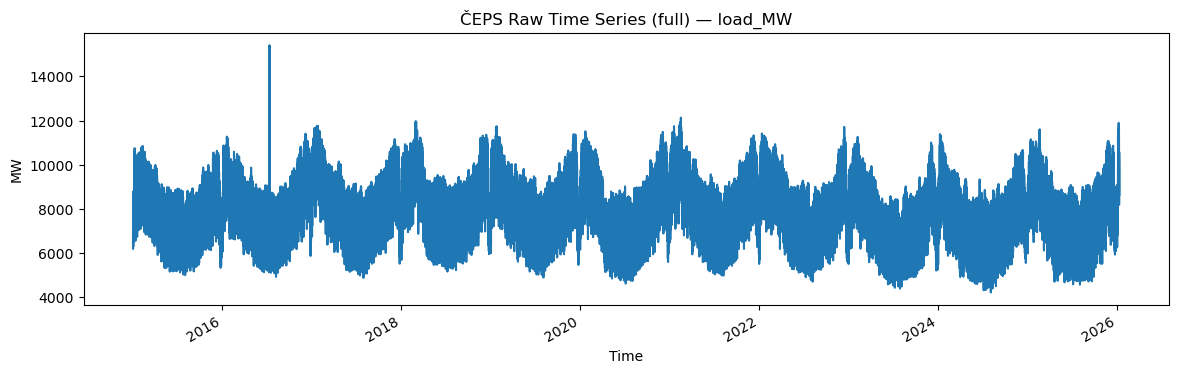

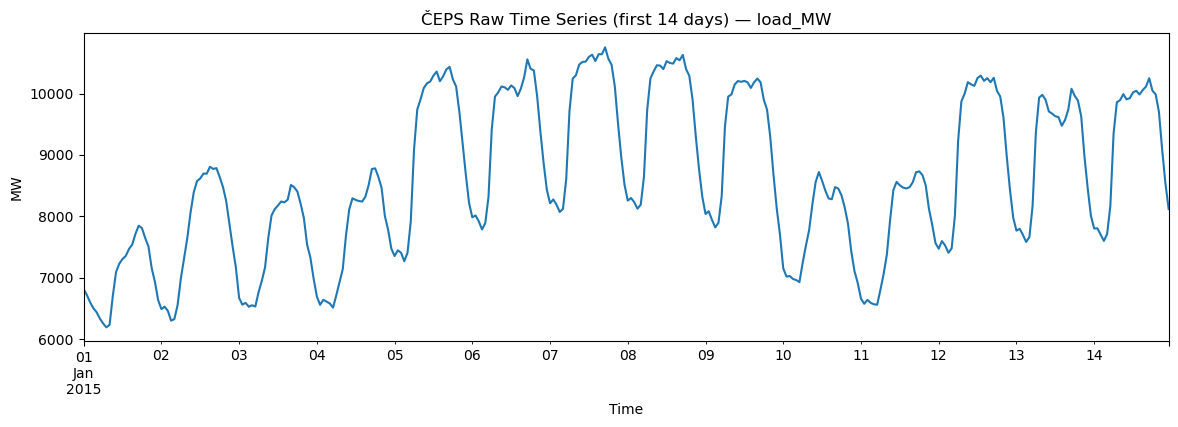


=== MISSING VALUES (COUNT) ===
0
load_MW                 0
load_with_pumping_MW    0
dtype: int64

=== MISSING VALUES (%) ===
0
load_MW                 0.0
load_with_pumping_MW    0.0
dtype: float64

=== FREQUENCY CHECK ===
Inferred frequency: None

Most common time deltas:
timestamp
0 days 01:00:00    96649
0 days 02:00:00       11
Name: count, dtype: int64

If reindexed to 'h', missing target values would be: 0.0114%

=== HEAD (REINDEXED) ===


,load_MW,load_with_pumping_MW
2015-01-01 00:00:00,6815.350,6815.350
2015-01-01 01:00:00,6721.000,6721.000
2015-01-01 02:00:00,6601.800,6606.917
2015-01-01 03:00:00,6506.400,6634.833
2015-01-01 04:00:00,6441.067,6957.633



=== SUMMARY STATS ===


,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
load_MW,96661.0,7988.170989,1403.586604,4224.167,6922.017,7970.90,8931.917,15412.6
load_with_pumping_MW,96661.0,8153.807181,1354.685052,4224.167,7183.133,8169.05,9069.500,15412.6



=== TIME FEATURES ADDED ===


,load_MW,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos
2015-01-01 00:00:00,6815.350,0,3,0.000000,1.000000,0.433884,-0.900969
2015-01-01 01:00:00,6721.000,1,3,0.258819,0.965926,0.433884,-0.900969
2015-01-01 02:00:00,6601.800,2,3,0.500000,0.866025,0.433884,-0.900969
2015-01-01 03:00:00,6506.400,3,3,0.707107,0.707107,0.433884,-0.900969
2015-01-01 04:00:00,6441.067,4,3,0.866025,0.500000,0.433884,-0.900969


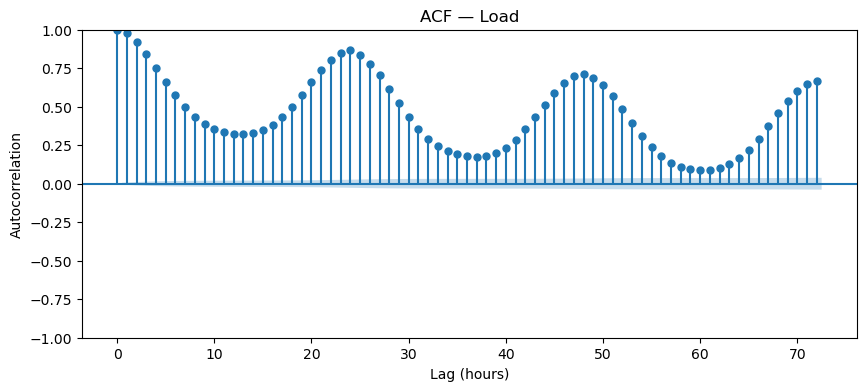

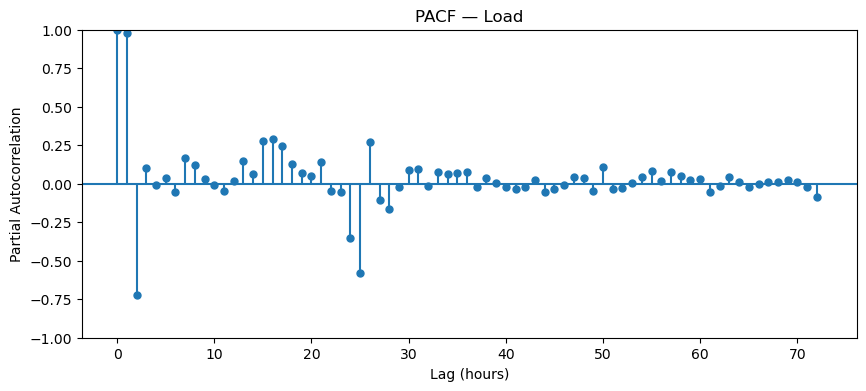


Remaining NaNs in target (filled version): 0

FINAL CONCLUSION
Verdict: SUITABLE
1) Long history available (~11.0 years).
2) Data are (mostly) hourly, suitable for time-series forecasting.
3) Missing values are low/moderate (0.00%).

Saved preprocessed dataset to: ceps_preprocessed.csv


In [5]:
# ============================================================
# ČEPS Dataset Assessment + Preprocessing (NO TRAINING)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# =========================
# SETTINGS (EDIT)
# =========================
FILE_NAME = "data (1).csv"   # your downloaded file name
EXPECTED_FREQ = "h"          # hourly frequency (use 'h')
TARGET_COL = "load_MW"       # target column
SAVE_CLEAN_FILE = "ceps_preprocessed.csv"
# =========================


# ============================================================
# 1) LOAD + CLEAN
# ============================================================
raw = pd.read_csv(FILE_NAME, sep=";", skiprows=1)

# Promote first data row to header; drop it from data
raw.columns = raw.iloc[0]
raw = raw.drop(index=0).reset_index(drop=True)

# Drop empty columns whose names are NaN (happens due to trailing separators)
raw = raw.loc[:, raw.columns.notna()]

# Rename Czech → English if present
raw = raw.rename(columns={
    "Datum": "timestamp",
    "Zatížení [MW]": "load_MW",
    "Zatížení s čerpáním [MW]": "load_with_pumping_MW",
})

# Keep only relevant columns if they exist
keep_cols = [c for c in ["timestamp", "load_MW", "load_with_pumping_MW"] if c in raw.columns]
df = raw[keep_cols].copy()

# Convert numeric columns (handles decimal commas)
for col in ["load_MW", "load_with_pumping_MW"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace(",", ".", regex=False)
            .replace("nan", np.nan)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Parse timestamp (ČEPS format: dd.mm.yyyy HH:MM)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d.%m.%Y %H:%M", errors="coerce")
df = df.dropna(subset=["timestamp"])

# Sort and set index
df = df.sort_values("timestamp").set_index("timestamp")

print("=== LOADED DATA ===")
print("Shape:", df.shape)
print("Range:", df.index.min(), "→", df.index.max())
print("Columns:", list(df.columns))


# ============================================================
# 2) HANDLE DUPLICATE TIMESTAMPS (IMPORTANT)
# ============================================================
dup_count = df.index.duplicated().sum()
print("\n=== DUPLICATES ===")
print("Duplicate timestamps:", dup_count)

if dup_count > 0:
    # Average duplicates (standard for load)
    df = df.groupby(df.index).mean(numeric_only=True)

print("Index unique now?:", df.index.is_unique)


# ============================================================
# 3) BASIC INSPECTION
# ============================================================
print("\n=== HEAD ===")
display(df.head())

# Ensure target exists
if TARGET_COL not in df.columns:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found.")
    TARGET_COL = numeric_cols[0]
    print("TARGET_COL not found; using:", TARGET_COL)


# ============================================================
# 4) PLOT RAW TIME SERIES (FULL + FIRST 14 DAYS)
# ============================================================
plt.figure(figsize=(14,4))
df[TARGET_COL].plot()
plt.title(f"ČEPS Raw Time Series (full) — {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

plt.figure(figsize=(14,4))
df[TARGET_COL].iloc[:24*14].plot()
plt.title(f"ČEPS Raw Time Series (first 14 days) — {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()


# ============================================================
# 5) MISSING VALUES CHECK
# ============================================================
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

print("\n=== MISSING VALUES (COUNT) ===")
print(missing_counts)
print("\n=== MISSING VALUES (%) ===")
print(missing_pct.round(4))


# ============================================================
# 6) FREQUENCY CHECK + REINDEX TO HOURLY GRID
# ============================================================
freq_inferred = pd.infer_freq(df.index)
delta_counts = df.index.to_series().diff().value_counts().head(10)

print("\n=== FREQUENCY CHECK ===")
print("Inferred frequency:", freq_inferred)
print("\nMost common time deltas:")
print(delta_counts)

# Reindex to uniform hourly index (this shows missing timestamps)
full_index = pd.date_range(df.index.min(), df.index.max(), freq=EXPECTED_FREQ)
df_hourly = df.reindex(full_index)

missing_after_reindex = df_hourly[TARGET_COL].isna().mean() * 100
print(f"\nIf reindexed to '{EXPECTED_FREQ}', missing target values would be: {missing_after_reindex:.4f}%")

print("\n=== HEAD (REINDEXED) ===")
display(df_hourly.head())


# ============================================================
# 7) DESCRIBE FEATURES (STATS)
# ============================================================
print("\n=== SUMMARY STATS ===")
display(df.describe().T)


# ============================================================
# 8) PREPROCESSING: TIME ENCODING (sin/cos)
# ============================================================
work = df_hourly.copy()

work["hour"] = work.index.hour
work["dayofweek"] = work.index.dayofweek  # Monday=0..Sunday=6

work["hour_sin"] = np.sin(2 * np.pi * work["hour"] / 24)
work["hour_cos"] = np.cos(2 * np.pi * work["hour"] / 24)

work["dow_sin"] = np.sin(2 * np.pi * work["dayofweek"] / 7)
work["dow_cos"] = np.cos(2 * np.pi * work["dayofweek"] / 7)

print("\n=== TIME FEATURES ADDED ===")
display(work[[TARGET_COL, "hour", "dayofweek", "hour_sin", "hour_cos", "dow_sin", "dow_cos"]].head())


# ============================================================
# 9) ACF & PACF (drop NaNs only for plotting)
# ============================================================
series_for_corr = work[TARGET_COL].dropna()

plt.figure(figsize=(10,4))
plot_acf(series_for_corr, lags=72, ax=plt.gca())
plt.title("ACF — Load")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(series_for_corr, lags=72, ax=plt.gca(), method="ywm")
plt.title("PACF — Load")
plt.xlabel("Lag (hours)")
plt.ylabel("Partial Autocorrelation")
plt.show()


# ============================================================
# 10) OPTIONAL: SIMPLE IMPUTATION (FOR FUTURE MODELING)
#     - Keep original NaNs for assessment
#     - Create a second version with filled values
# ============================================================
work_filled = work.copy()
work_filled[TARGET_COL] = work_filled[TARGET_COL].interpolate(method="time")
work_filled[TARGET_COL] = work_filled[TARGET_COL].ffill().bfill()

print("\nRemaining NaNs in target (filled version):", work_filled[TARGET_COL].isna().sum())


# ============================================================
# 11) SUITABILITY CONCLUSION (AUTOMATIC TEXT)
# ============================================================
time_span_years = (df.index.max() - df.index.min()).days / 365.25
missing_original_pct = float(missing_pct.get(TARGET_COL, np.nan))

dominant_delta_is_hour = (len(delta_counts) > 0 and delta_counts.index[0] == pd.Timedelta(hours=1))
regular_hourly = (freq_inferred in ["h", "H"]) or dominant_delta_is_hour

suitable = True
reasons = []

if time_span_years >= 1:
    reasons.append(f"Long history available (~{time_span_years:.1f} years).")
else:
    suitable = False
    reasons.append(f"Time span too short (~{time_span_years:.2f} years).")

if regular_hourly:
    reasons.append("Data are (mostly) hourly, suitable for time-series forecasting.")
else:
    reasons.append("Data show irregular sampling; reindexing/resampling required but still feasible.")

if not np.isnan(missing_original_pct):
    if missing_original_pct <= 5:
        reasons.append(f"Missing values are low/moderate ({missing_original_pct:.2f}%).")
    else:
        suitable = False
        reasons.append(f"Missing values are high ({missing_original_pct:.2f}%).")
else:
    reasons.append("Missing values could not be computed reliably for the target.")

print("\n" + "="*60)
print("FINAL CONCLUSION")
print("="*60)
print("Verdict:", "SUITABLE" if suitable else "NOT SUITABLE")
for i, r in enumerate(reasons, 1):
    print(f"{i}) {r}")
print("="*60)


# ============================================================
# 12) SAVE PREPROCESSED DATA FOR LATER MODELING
# ============================================================
work_filled.to_csv(SAVE_CLEAN_FILE, index_label="timestamp")
print(f"\nSaved preprocessed dataset to: {SAVE_CLEAN_FILE}")
